Установка необходимых библиотек

In [6]:
pip install gym torch matplotlib

Импорт необходимых библиотек

In [7]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

Определение класса нейронной сети для актера и критика

In [8]:
class ActorCritic(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.actor(x), self.critic(x)


Определение функции вычисления возвратов

In [9]:
def compute_returns(rewards, gamma):
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return torch.tensor(returns)


Определение функции обучения

In [10]:
def train(env, model, optimizer, gamma, num_episodes):
    episode_rewards = []
    for episode in range(num_episodes):
        state = env.reset()
        done = False

        log_probs = []
        values = []
        rewards = []

        while not done:
            state = torch.FloatTensor(state).unsqueeze(0)
            action_probs, value = model(state)
            action = torch.multinomial(action_probs, 1)
            log_prob = torch.log(action_probs.squeeze(0)[action])

            next_state, reward, done, _ = env.step(action.item())

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(reward)

            state = next_state

        returns = compute_returns(rewards, gamma)
        log_probs = torch.cat(log_probs)
        values = torch.cat(values).squeeze(1)

        advantage = returns - values

        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        loss = actor_loss + critic_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        episode_reward = sum(rewards)
        episode_rewards.append(episode_reward)

        if episode % 10 == 0:
            print(f"Episode {episode}, Loss: {loss.item()}, Reward: {episode_reward}")

    visualize_rewards(episode_rewards)


Определение функции визуализации наград

In [11]:
def visualize_rewards(rewards):
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards over Episodes')
    plt.show()


Создание среды и параметров обучения

In [12]:
env = gym.make('CartPole-v1')
input_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 128

model = ActorCritic(input_dim, action_dim, hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=0.01)
gamma = 0.99
num_episodes = 1000


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Обучение модели

Episode 0, Loss: 49.802066802978516, Reward: 11.0
Episode 10, Loss: 32.32720947265625, Reward: 13.0
Episode 20, Loss: 76.45092010498047, Reward: 24.0
Episode 30, Loss: 523.6838989257812, Reward: 69.0
Episode 40, Loss: 778.0816650390625, Reward: 103.0
Episode 50, Loss: 152.13258361816406, Reward: 60.0
Episode 60, Loss: 266.7174072265625, Reward: 77.0
Episode 70, Loss: 383.8011779785156, Reward: 95.0
Episode 80, Loss: 87.1123046875, Reward: 44.0
Episode 90, Loss: 153.18765258789062, Reward: 70.0
Episode 100, Loss: 58.00005340576172, Reward: 65.0
Episode 110, Loss: 147.7339630126953, Reward: 105.0
Episode 120, Loss: 321.9170837402344, Reward: 164.0
Episode 130, Loss: 89.71815490722656, Reward: 134.0
Episode 140, Loss: 63.420616149902344, Reward: 155.0
Episode 150, Loss: 265.264404296875, Reward: 144.0
Episode 160, Loss: 28.41108512878418, Reward: 102.0
Episode 170, Loss: 1184.243896484375, Reward: 120.0
Episode 180, Loss: 665.40576171875, Reward: 217.0
Episode 190, Loss: 675.8180541992188

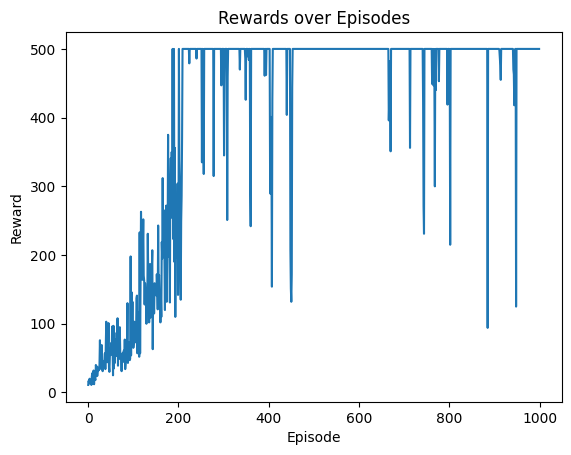

In [13]:
train(env, model, optimizer, gamma, num_episodes)
